<a href="https://colab.research.google.com/github/AJAV-TIP/ApplicationExample/blob/main/Sensitivity_Zhu_et_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCT Calculation for La$_{0.5}$Ce$_{0.5}$Ni$_{4}$Co at 40 °C as Reported by (Zhu et al., 2022)

Import common libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

Import library to retrieve molecular weight and density of constituent elements of the sample

In [ ]:
!pip install periodictable
import periodictable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for periodictable: filename=periodictable-1.7.0-py3-none-any.whl size=752513 sha256=1730481fb158794633d91d0641dfe7f04e925503e9112ef41b3178693ffd6419
  Stored in directory: /root/.cache/pip/wheels/7e/19/a2/fef5d0ca2b1ad2b199e863a6e796ad9d5efc86563d80c91a0c
Successfully built periodictable


Import library to obtain compressibility factor or other thermodynamic properties from an Equation of State (EoS)

In [ ]:
!pip install CoolProp
import CoolProp.CoolProp as CP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 7.4 MB/s eta 0:00:00


  Read pressure sensor data from a CSV file hosted in a public GitHub repository and store it in the objects `Pf` (Final Pressure) and `Pi` (Initial Pressure)

In [ ]:
url = ('https://raw.githubusercontent.com/AJAV-TIP/ApplicationExample/main/Zhu_et_al_2022.csv')
dataframe = pd.read_csv(url)
print(dataframe.info())

Pf = dataframe['Pf_(MPa)']
Pi = dataframe['Pi_(MPa)']

dataframe.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pi_(MPa)  24 non-null     float64
 1   Pf_(MPa)  24 non-null     float64
dtypes: float64(2)
memory usage: 512.0 bytes
None


,Pi_(MPa),Pf_(MPa)
0,0.000000,0.000001
1,0.090528,0.045081
2,0.116287,0.080403
3,0.168508,0.123850


Declare the elements of the material to be analyzed and retrieve the molecular weights and densities of the elements from the ‘Periodictable’ library.



In [ ]:
# List the symbols of the elements in your sample.
element_symbols = ['La', 'Ce', 'Ni', 'Co']
Mw=[]
# Function to retrieve and store molecular weights in the vector.
def get_Mw(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        Mw.append(element.mass)
# Function evaluation
get_Mw(element_symbols)

rho = []
# Function to retrieve and store solid state densities in the vector.
def get_rho(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        rho.append(element.density)

get_rho(element_symbols)

# Results of consult at the Periodic table library
Mw_H2 = 2*periodictable.elements.symbol('H').mass
rho_H = periodictable.elements.symbol('H').density

print("Elements densities",rho,"g/cm^3")
print("Molecular weights",Mw,"g/mol")
print("H density",rho_H,"g/cm^3")
print("H2 molecular weight",Mw_H2,"g/mol")

Elements densities [6.145, 6.77, 8.902, 8.9] g/cm^3
Molecular weights [138.9055, 140.116, 58.6934, 58.9332] g/mol
H density 0.0708 g/cm^3
H2 molecular weight 2.01588 g/mol


The sample weight is included, along with the coefficients of the elements that make up the sample, and the initial mass fractions are calculated

In [ ]:
m_host = 1.6194 # g of sample
Mw = np.array(Mw)
rho = np.array(rho)
Coeff = np.array([0.5, 0.5, 4, 1]) # coefficients of the elements that make up the sample
Mw_host = np.dot(Mw,Coeff) # molecular weight of the sample
w_i = Mw*Coeff/Mw_host # initial mass fractions

Insert the calibrated volumes

In [ ]:
V_rev = 12.098 #Reference volume Z.I
V_tube = 8.823 #Tube volume Z.II
V_sc = 2.91 # Sample cell volume Z.III

Insert temperatures

In [ ]:
T_rev = 298 # Reference  T (K) Z.I
T_tube = 298 # Tubes  T (K) Z.I
T_sc = 313 # Sample cell  T (K) Z.I

In [ ]:
dfX = pd.DataFrame(index=range(len(Pi)),columns=['Corrected','Den', 'Vol'])

Calculate hydrogen uptake in wt%

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022
m_x[0] = m_host # mass of the sample at initial time

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Corrected = pd.DataFrame(X)
dfX.Corrected

0     0.000000
1     0.014890
2     0.013113
3     0.018717
4     0.026203
5     0.031819
6     0.043048
7     0.058023
8     0.074867
9     0.095451
10    0.134736
11    0.282611
12    0.531526
13    0.767338
14    1.012531
15    1.210917
16    1.330684
17    1.386806
18    1.405513
19    1.418602
20    1.431679
21    1.440995
22    1.446590
23    1.450386
Name: Corrected, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022
m_x[0] = m_host # mass of the sample at initial time

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[0]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Den = pd.DataFrame(X)
dfX.Den

0     0.000000
1     0.014890
2     0.013065
3     0.018778
4     0.026252
5     0.031928
6     0.043298
7     0.058326
8     0.075364
9     0.096335
10    0.136104
11    0.283524
12    0.531228
13    0.767506
14    1.016394
15    1.218581
16    1.349239
17    1.417169
18    1.446403
19    1.465638
20    1.493642
21    1.516893
22    1.530640
23    1.506394
Name: Den, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022
m_x[0] = m_host # mass of the sample at initial time

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[0]/rho_x[0]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Vol = pd.DataFrame(X)
dfX.Vol

0     0.000000
1     0.014890
2     0.013065
3     0.018666
4     0.026058
5     0.031526
6     0.042619
7     0.057306
8     0.073718
9     0.093665
10    0.132079
11    0.280154
12    0.527658
13    0.759421
14    1.000661
15    1.193928
16    1.300139
17    1.346590
18    1.358283
19    1.368264
20    1.366875
21    1.362254
22    1.361579
23    1.395085
Name: Vol, dtype: float64

Generate plot

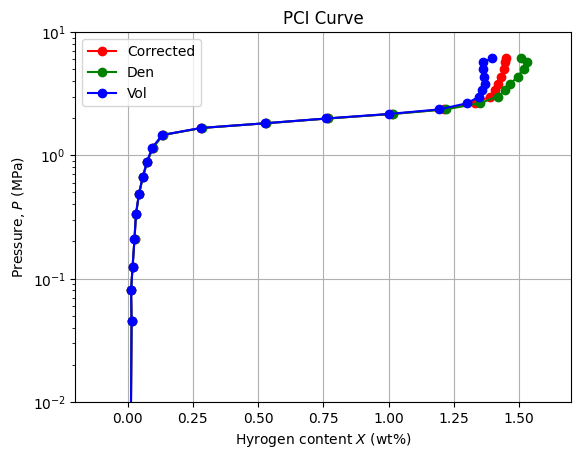

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Hyrogen content $X$ (wt%)')
ax.set_ylabel('Pressure, $P$ (MPa)')
ax.set_xlim([-0.2,1.7])
ax.set_ylim([0.01,10])
ax.set_yscale('log')
ax.grid(True)

ax.plot(dfX.Corrected,Pf,'o-',color = 'r', label = 'Corrected')
ax.plot(dfX.Den,Pf,'o-',color = 'g', label = 'Den')
ax.plot(dfX.Vol,Pf,'o-',color = 'b', label = 'Vol')

ax.legend()
ax.set_title('PCI Curve')
plt.show()

In [ ]:
dfX

,Corrected,Den,Vol
0,0.000000,0.000000,0.000000
1,0.014890,0.014890,0.014890
2,0.013113,0.013065,0.013065
3,0.018717,0.018778,0.018666
4,0.026203,0.026252,0.026058
5,0.031819,0.031928,0.031526
6,0.043048,0.043298,0.042619
7,0.058023,0.058326,0.057306
8,0.074867,0.075364,0.073718
9,0.095451,0.096335,0.093665
